# Exproratory Data Analysis
In this lab we are performing exploratory data analysis (EDA) on the Datasets. We are analysing the distribution of the returns of each 5 minutes, 1 hour and 1 day timeframes, the number and percentage of the outliers, the ADF test and ...

We will first import the libraries and the datasets.

In [2]:
!pip install scipy
!pip install statsmodels
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
import scipy.stats as stats

# Importing datasets
df_1h = pd.read_csv('../data/btcusdt_1h_2018_indicators.csv')
df_1d = pd.read_csv('../data/btcusdt_1d_2018_preprocessed.csv')
df_5m = pd.read_csv('../data/btcusdt_5m_2018_preprocessed.csv')




## Data Distribution
We are first seeing the distribution that bitcoin's returns follow, and we are comparing it with a normal distribution. In order to do that we are first calculating the kurtosis. 

**Notes:** When adding returns it is easier to add logaritmic returns than simple returns.

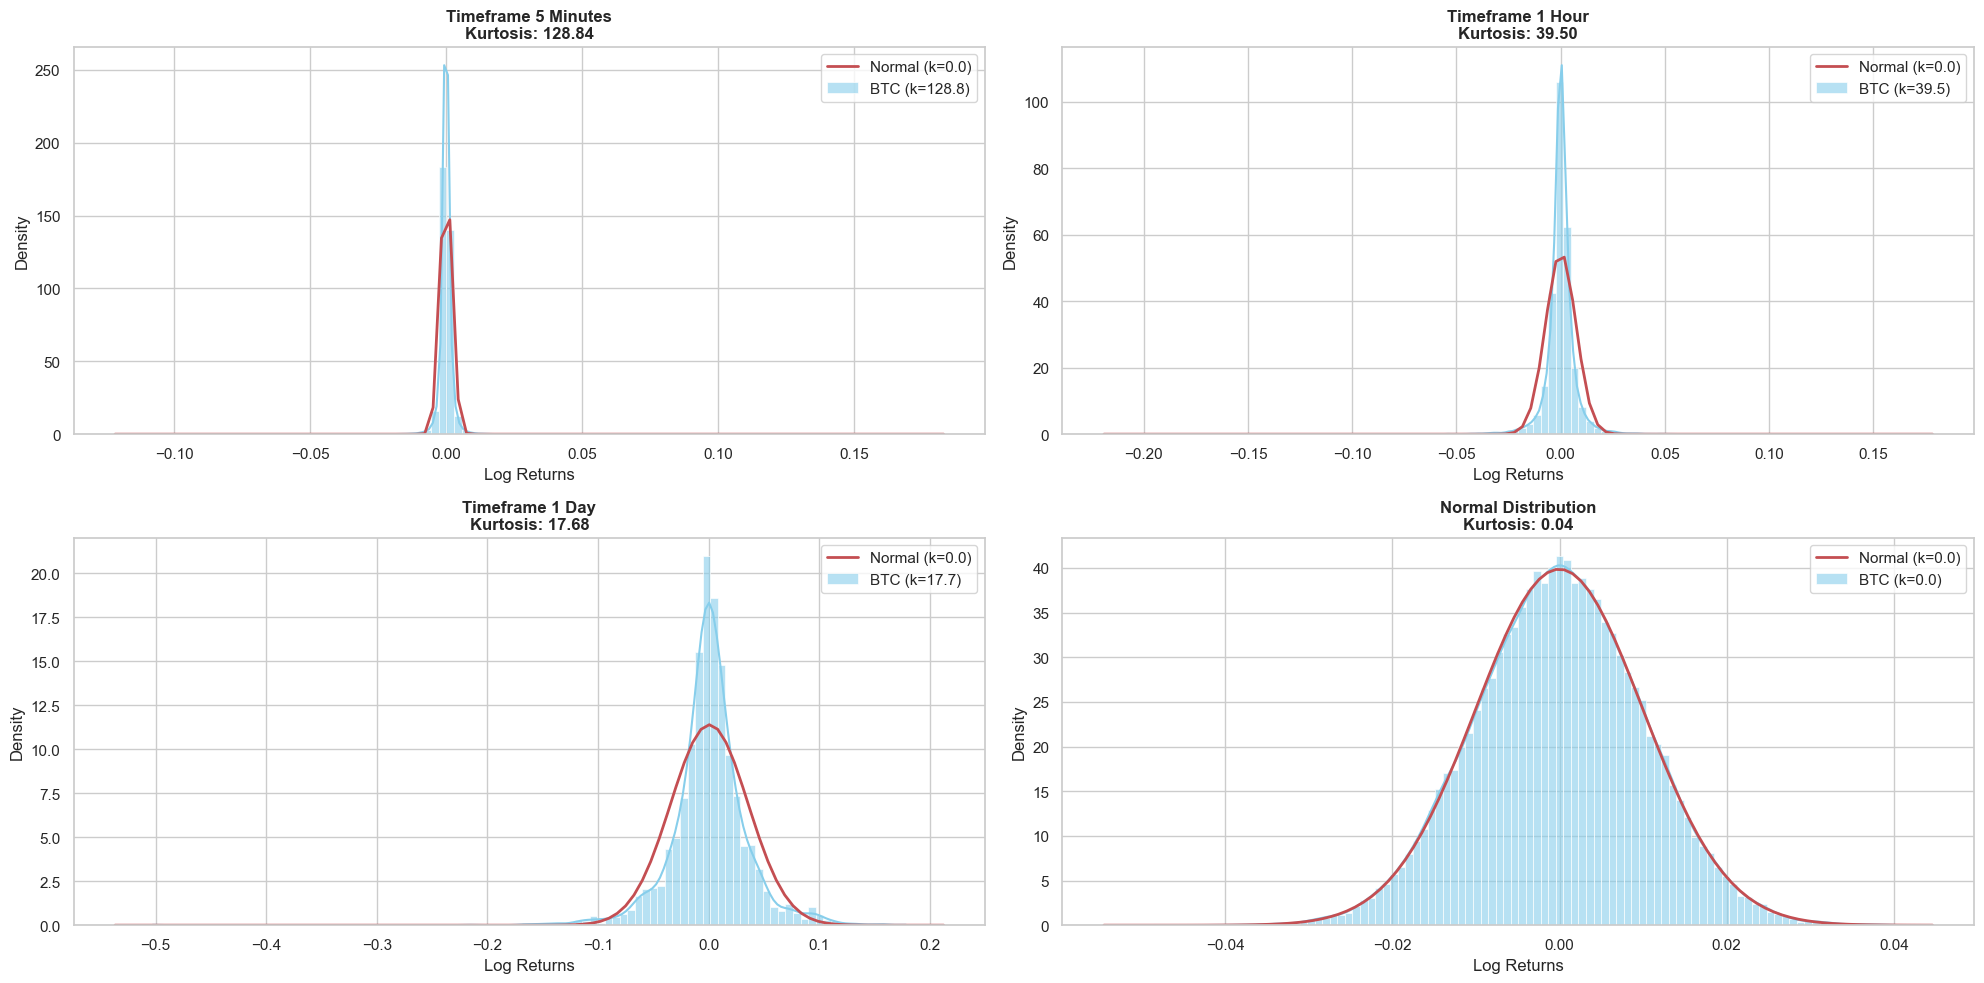

In [3]:
# configuration for multiple plots
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# Generating normal distribution dataset
datos = np.random.normal(loc=0, scale=0.01, size=60000)
initial_price = 10000
df_normal = initial_price * np.exp(np.cumsum(datos))
df_normal = pd.DataFrame(df_normal, columns=['Close'])

# List of datasets and their names
datasets = [
    (df_5m, "Timeframe 5 Minutes"),
    (df_1h, "Timeframe 1 Hour"),
    (df_1d, "Timeframe 1 Day"),
    (df_normal, "Normal Distribution")
]

# Loop through datasets and plot
for ax, (df, name) in zip(axes.flatten(), datasets):
    
    # Logaritmic Returns Calculation
    data = df.copy()
    data['log_return'] = np.log(data['Close'] / data['Close'].shift(1))
    data.dropna(inplace=True)
    
    # Kurtosis Calculation
    k_val = stats.kurtosis(data['log_return'], fisher=True)
    
    # Logaritmic returns Histogram
    sns.histplot(data['log_return'], bins=100, kde=True, stat="density", 
                 color='skyblue', alpha=0.6, label=f"BTC (k={k_val:.1f})", ax=ax)
    
    # Normal distribution line
    mu, std = stats.norm.fit(data['log_return'])
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)

    # Plot normal distribution
    ax.plot(x, p, 'r', linewidth=2, label="Normal (k=0.0)")
    ax.set_title(f'{name}\nKurtosis: {k_val:.2f}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Log Returns')
    ax.set_ylabel('Density')
    ax.legend()
plt.tight_layout()
plt.show()

As we can appreciate, the three timeframes' distributions are leptokurtic. However, the higher the timeframe the lower the kurtosis. This is a crucial factor to take into account when deciding which model could suit best. Models that work better with a normal distribution (for instance, KNN or linear regression) will have a  outperform in high timeframes. On the other hand, the best model choice in a low timeframe are the decision trees.

In order to see clearer the outliers we are creating some boxplots.

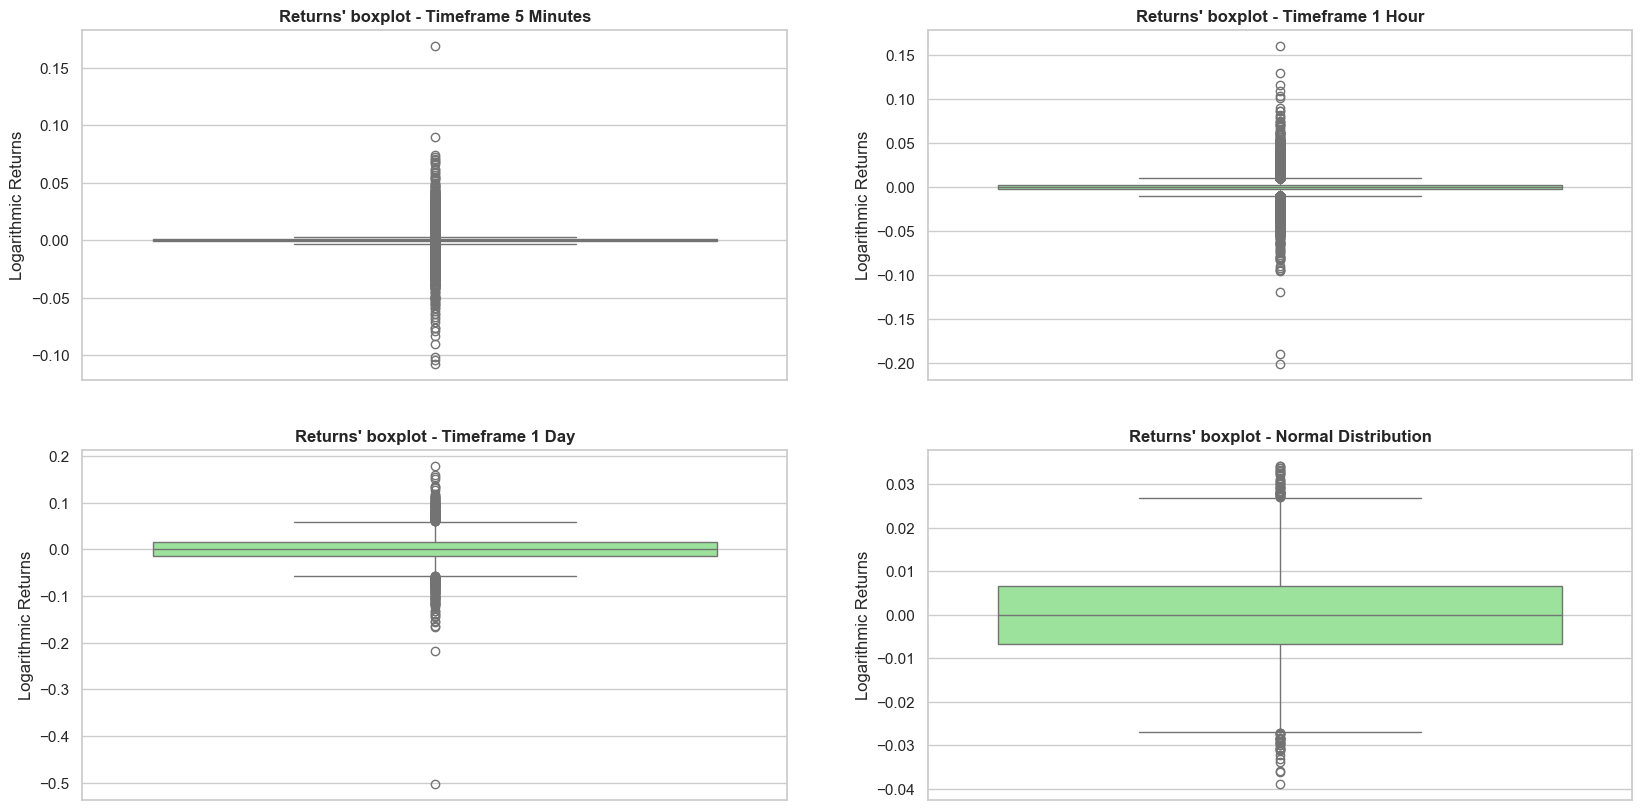

In [4]:
# Preparing data for BoxPlots
datos = np.random.normal(loc=0, scale=0.01, size=10000)
initial_price = 10000
df_normal = initial_price * np.exp(np.cumsum(datos))
df_normal = pd.DataFrame(df_normal, columns=['Close'])
datasets = [
    (df_5m, "Timeframe 5 Minutes"),
    (df_1h, "Timeframe 1 Hour"),
    (df_1d, "Timeframe 1 Day"),
    (df_normal, "Normal Distribution")
]
# Plotting BoxPlots
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
for ax, (df, name) in zip(axes.flatten(), datasets):
    data = df.copy()
    data['log_return'] = np.log(data['Close'] / data['Close'].shift(1))
    data.dropna(inplace=True)
    
    sns.boxplot(y=data['log_return'], ax=ax, color='lightgreen')
    ax.set_title(f"Returns' boxplot - {name}", fontsize=12, fontweight='bold')
    ax.set_ylabel('Logarithmic Returns')

As it was expected, the higher the timeframe the wider the boxplots' body. Eventhough 1 day timeframe's boxplot has the wider box, it is far away from the normal distribution boxplot.

Now, we are counting the outliers of each timeframe.

In [5]:
# Counting outliers function
def count_outliers(df, name):
    # Logaritmic returns
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
    data = df['log_return'].dropna()
    # Selecting the outliers
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    body = q3 - q1
    lower_bound = q1 - 1.5 * body
    upper_bound = q3 + 1.5 * body
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    
    # Counting outliers
    num_outliers = len(outliers)
    num_data = len(data)
    percentage = (num_outliers / num_data) * 100
    max_outlier = np.exp(max(outliers)) - 1
    min_outlier = np.exp(min(outliers)) - 1
    
    # Printing the results
    print(f"OUTLIERS RESULTS OF {name}")
    print(f"№ The number of outliers is: {num_outliers}.")
    print(f"📊 The percentage of outliers is: {percentage:.2f}%.")
    print(f"📈 The highest value is: +{max_outlier:.2f}%. ")
    print(f"📉 The lowest value is: {min_outlier:.2f}%.")
    print('-'*50)

    return outliers

# Counting outliers for each dataset
outliers_5m = count_outliers(df_5m, "BTC/USDT 5 minutes")
outliers_1h = count_outliers(df_1h, "BTC/USDT 1 hour")
outliers_1d = count_outliers(df_1d, "BTC/USDT 1 day")
outliers_normal = count_outliers(df_normal, "Normal Distribution")

OUTLIERS RESULTS OF BTC/USDT 5 minutes
№ The number of outliers is: 70808.
📊 The percentage of outliers is: 8.54%.
📈 The highest value is: +0.18%. 
📉 The lowest value is: -0.10%.
--------------------------------------------------
OUTLIERS RESULTS OF BTC/USDT 1 hour
№ The number of outliers is: 6683.
📊 The percentage of outliers is: 9.67%.
📈 The highest value is: +0.17%. 
📉 The lowest value is: -0.18%.
--------------------------------------------------
OUTLIERS RESULTS OF BTC/USDT 1 day
№ The number of outliers is: 251.
📊 The percentage of outliers is: 8.70%.
📈 The highest value is: +0.20%. 
📉 The lowest value is: -0.40%.
--------------------------------------------------
OUTLIERS RESULTS OF Normal Distribution
№ The number of outliers is: 70.
📊 The percentage of outliers is: 0.70%.
📈 The highest value is: +0.03%. 
📉 The lowest value is: -0.04%.
--------------------------------------------------


As it was expected, bitcoins data has a lot more outliers than the synthetic data. Curiously, the three timeframes' datasets have the same amount of outliers, which strange after seing the boxplots. It is obvius that the higher the timeframe the higher the max/min outlier value is.

### Distribution conclusion
The leptokurtic distributions tells us that the models

## Seasonality
An essential characteristic to analize is seasonality. Depending on seasonality a model would suit better or not.

First we will plot an ACF (autocorrelative function graph)

In [6]:
# ADF Test
from statsmodels.tsa.stattools import adfuller
def adf_test(dframe, name):
    df = dframe.copy()
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
    data = df['log_return'].dropna()
    result = adfuller(data)
    print(f"ADF Test Results for {name}:")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    for key, value in result[4].items():
        print(f'Critical Value ({key}): {value}')
    if result[1] < 0.05:
        print("The series is stationary (reject H0)")
    else:
        print("The series is non-stationary (fail to reject H0)")
    print('-'*50)
adf_test(df_1d, "BTC/USDT 1 day")
adf_test(df_1h.tail(9000), "BTC/USDT 1 hour (Last year)")
adf_test(df_5m.tail(9000*20), "BTC/USDT 5 minutes (Last year)")

ADF Test Results for BTC/USDT 1 day:
ADF Statistic: -37.507321058352915
p-value: 0.0
Critical Value (1%): -3.4326210388587426
Critical Value (5%): -2.862543391373811
Critical Value (10%): -2.567304134167373
The series is stationary (reject H0)
--------------------------------------------------
ADF Test Results for BTC/USDT 1 hour (Last year):
ADF Statistic: -23.031013187334107
p-value: 0.0
Critical Value (1%): -3.4310786588922135
Critical Value (5%): -2.8618620198447844
Critical Value (10%): -2.566941406139108
The series is stationary (reject H0)
--------------------------------------------------
ADF Test Results for BTC/USDT 5 minutes (Last year):
ADF Statistic: -52.76838654339927
p-value: 0.0
Critical Value (1%): -3.430386343288607
Critical Value (5%): -2.861556063242812
Critical Value (10%): -2.566778549888355
The series is stationary (reject H0)
--------------------------------------------------


<Figure size 1200x600 with 0 Axes>

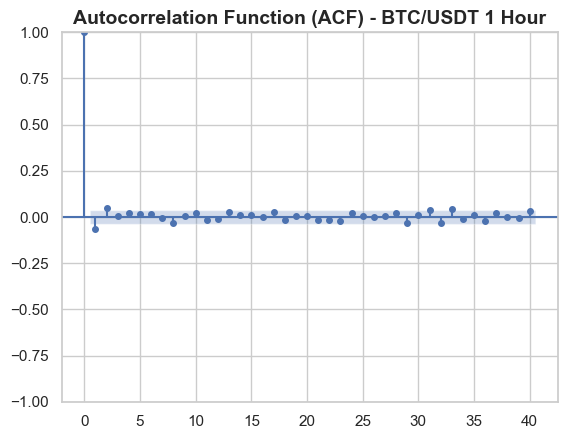

In [8]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Logarithmic returns for 1 Day dataset
df_1d['log_return'] = np.log(df_1d['Close'] / df_1d['Close'].shift(1))
df_1d.dropna(inplace=True)

# ACF and PACF plots function
plt.figure(figsize=(12, 6))
plot_acf(df_1d['log_return'], lags=40, markersize=4)
plt.title('Autocorrelation Function (ACF) - BTC/USDT 1 Hour', fontsize=14, fontweight='bold')
plt.show()